In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')



In [ ]:
#load cleaned dataset
df = pd.read_csv("data_clean/cleaned_obesity_dataset.csv")

#verify
cols = df.columns.tolist()
print(df["questionid"].value_counts().head(10))



questionid
Q036    20020
Q037    20020
Q047    20020
Q043     9240
Q044     9240
Q045     9240
Q046     9240
Q018     4620
Q019     4620
Name: count, dtype: int64


In [ ]:
#q036 obesity weighted mean across years

df["data_value"] = pd.to_numeric(df["data_value"], errors="coerce")
df["sample_size"] = pd.to_numeric(df["sample_size"], errors="coerce")

obesity_df = df[df["questionid"].eq("Q036")].copy()

def weighted_mean(g):
    x = g["data_value"].to_numpy(dtype=float)
    w = g["sample_size"].to_numpy(dtype=float)
    m = np.isfinite(x) & np.isfinite(w)
    if not m.any(): return np.nan
    ws = w[m].sum()
    if ws<=0: return np.nan
    return float(np.average(x[m], weights=w[m]))

group_keys = ["locationabbr","income","sex","ageyears","race_ethnicity","education"]

obesity_agg = (
    obesity_df.dropna(subset=["data_value","sample_size"])
              .groupby(group_keys, dropna=False)
              .apply(weighted_mean)
              .reset_index(name="obesity_pct")
)

print("obesity_agg shape:", obesity_agg.shape)
obesity_agg.head(10)
obesity_agg.to_csv("data_clean/obesity_agg.csv", index=False)


obesity_agg shape: (1353, 7)


In [ ]:
#collapse all questions exclude 36/37

#filter behavior rows
behavior_df = df[~df["questionid"].isin(["Q036","Q037"])].copy()

#helper
def weighted_mean(g):
    x = g["data_value"].to_numpy(dtype=float)
    w = g["sample_size"].to_numpy(dtype=float)
    m = np.isfinite(x) & np.isfinite(w)
    if not m.any():
        return np.nan
    ws = w[m].sum()
    if ws <= 0:
        return np.nan
    return float(np.average(x[m], weights=w[m]))

#group keys
group_keys = ["locationabbr","income","sex","ageyears","race_ethnicity","education","questionid"]

#collapse across years (weighted means)
behavior_agg = (
    behavior_df.dropna(subset=["data_value","sample_size"])
               .groupby(group_keys, dropna=False)
               .apply(weighted_mean)
               .reset_index(name="behavior_pct")
)

print("behavior_agg shape:", behavior_agg.shape)
behavior_agg.head(10)
behavior_agg.to_csv("data_clean/behavior_agg.csv", index=False)

behavior_agg shape: (9409, 8)


In [ ]:
#pivot behaviors wide and merge with obesity table
key_cols = ["locationabbr","income","sex","ageyears","race_ethnicity","education"]

#pivot wide by questionid
behavior_wide = (
    behavior_agg.pivot(index=key_cols, columns="questionid", values="behavior_pct")
                .reset_index()
)

#drop all-na predictor columns
pred_cols = [c for c in behavior_wide.columns if c not in key_cols]
behavior_wide = behavior_wide.loc[:, key_cols + [c for c in pred_cols if behavior_wide[c].notna().any()]]

#optional prefix for clarity
#rename_map = {c: f"q_{c}" for c in behavior_wide.columns if c not in key_cols}
#behavior_wide = behavior_wide.rename(columns=rename_map)

#merge with obesity
obesity_behavior = obesity_agg.merge(behavior_wide, on=key_cols, how="inner")

#print checks
print("obesity_behavior shape:", obesity_behavior.shape)
print("predictor columns:", len([c for c in obesity_behavior.columns if c.startswith("Q")]))
obesity_behavior.head(5)
obesity_behavior.to_csv("data_clean/obesity_behavior.csv", index=False)

obesity_behavior shape: (1353, 14)
predictor columns: 7


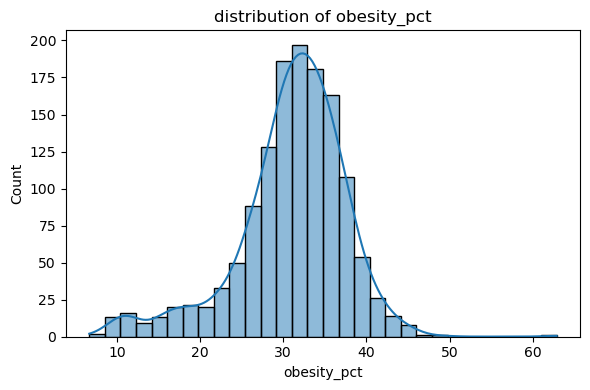

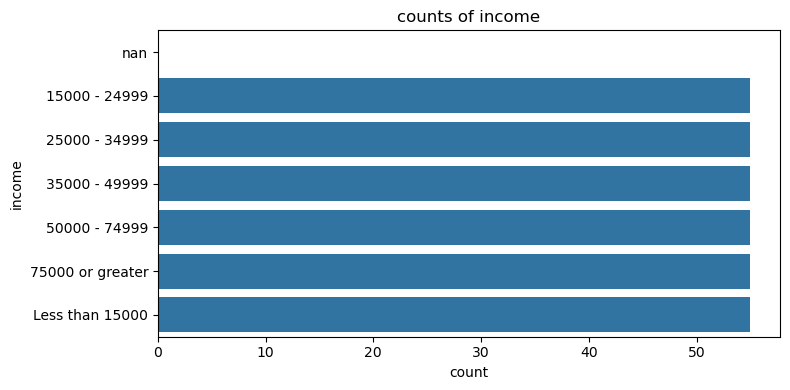

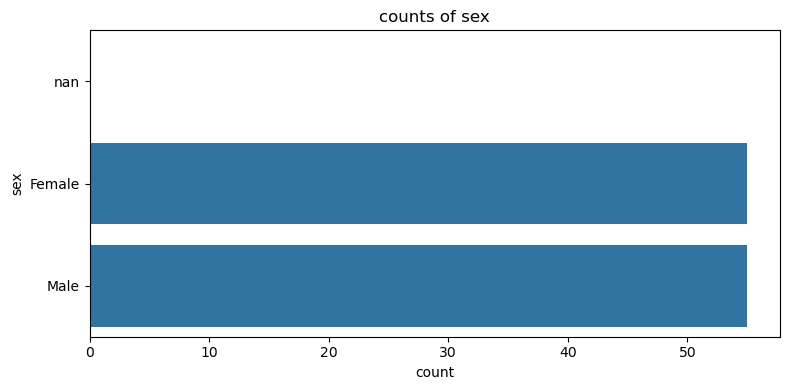

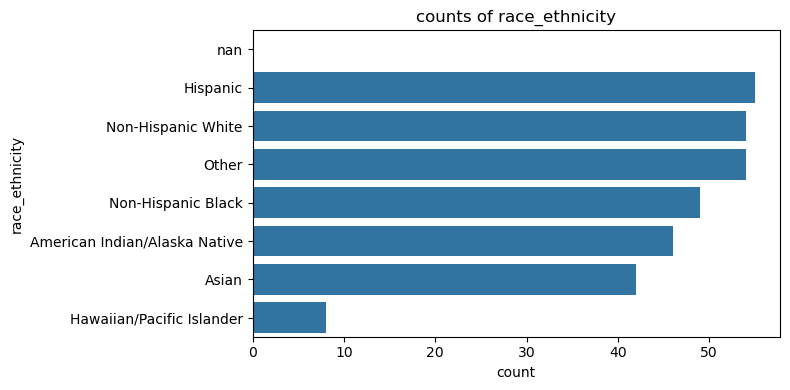

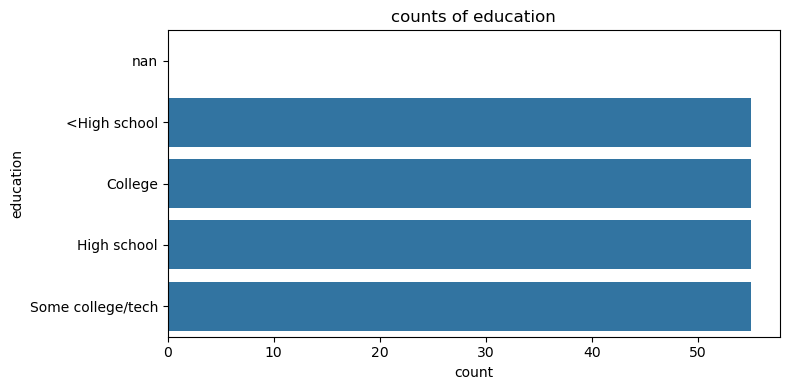

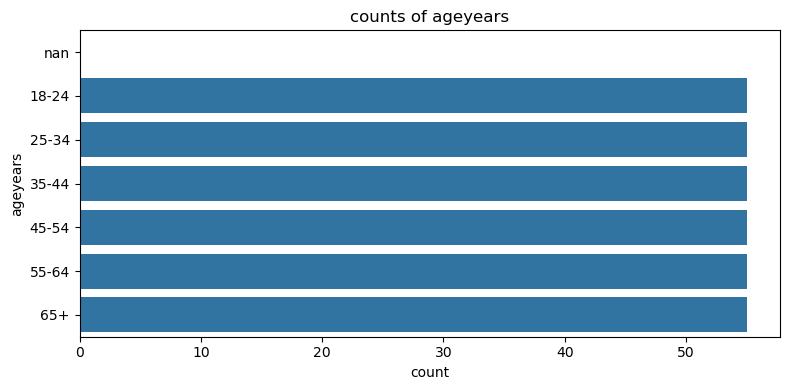

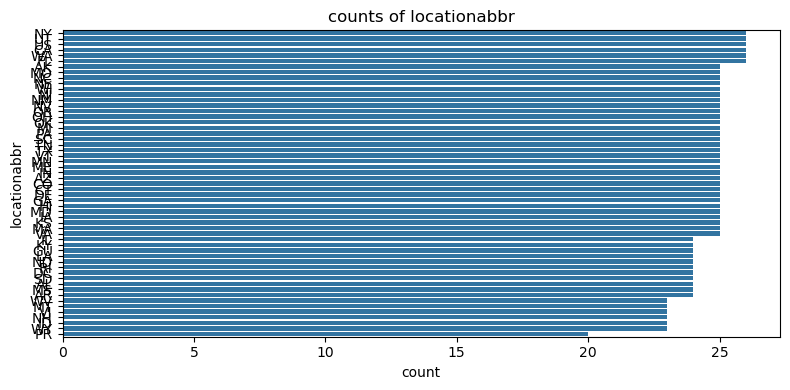

missingness (fraction):
 sex               0.918699
education         0.837398
race_ethnicity    0.772358
income            0.756098
ageyears          0.756098
obesity_pct       0.000000
dtype: float64


In [ ]:
#univariate eda

#numeric distributions

num_cols = ["obesity_pct"]
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(obesity_behavior[c].dropna(), kde=True, bins=30)
    plt.title(f"distribution of {c}")
    plt.tight_layout(); plt.show()

#categorical counts
cat_cols = ["income","sex","race_ethnicity","education","ageyears","locationabbr"]
for c in cat_cols:
    if c in obesity_behavior.columns:
        plt.figure(figsize=(8,4))
        order = obesity_behavior[c].value_counts(dropna=False).index
        sns.countplot(y=c, data=obesity_behavior, order=order)
        plt.title(f"counts of {c}")
        plt.tight_layout(); plt.show()

#missingness quick view
missing = obesity_behavior[["obesity_pct","income","sex","race_ethnicity","education","ageyears"]].isna().mean().sort_values(ascending=False)
print("missingness (fraction):\n", missing)


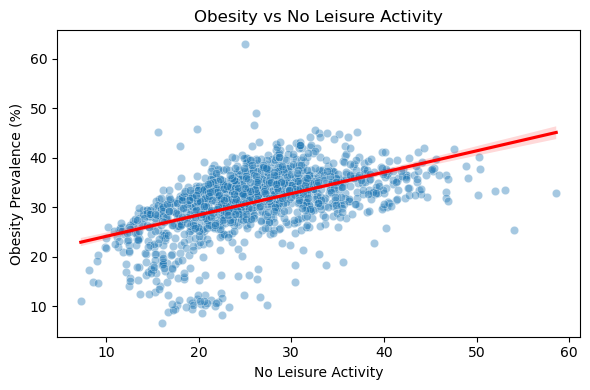

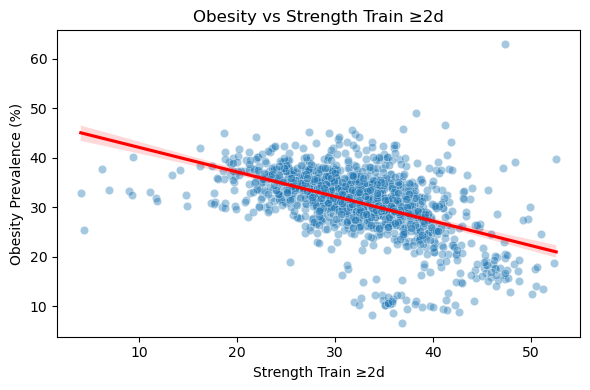

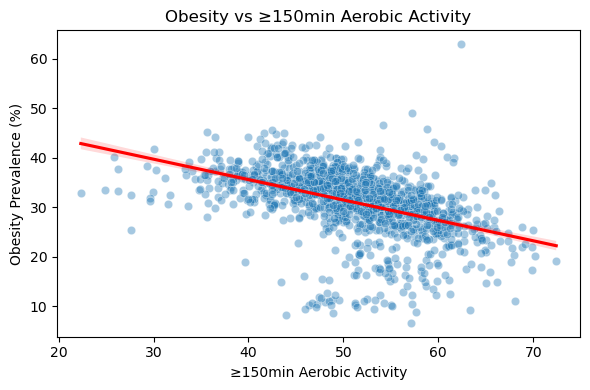

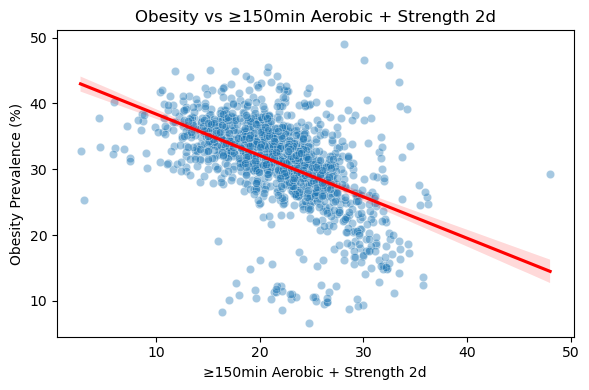

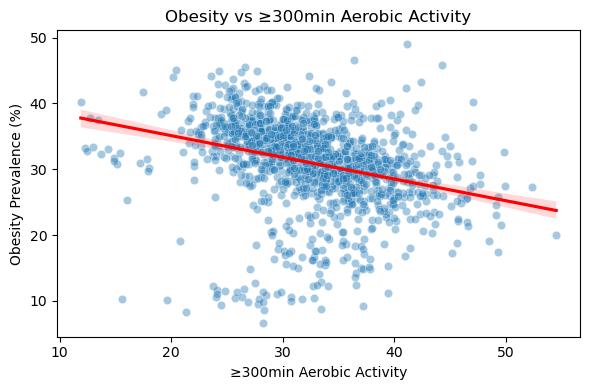

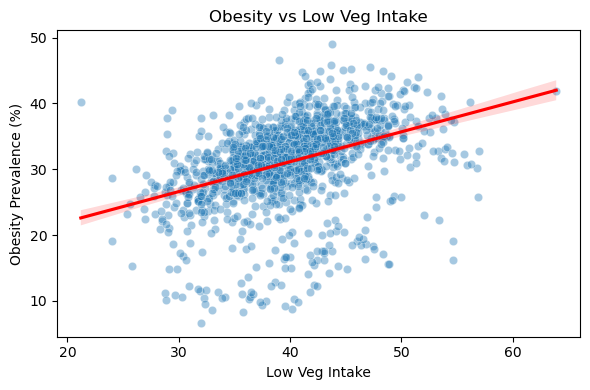

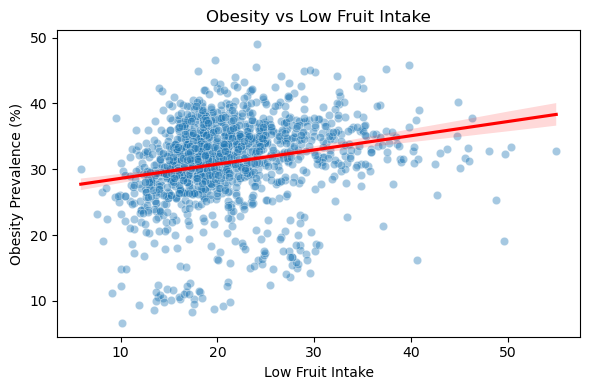

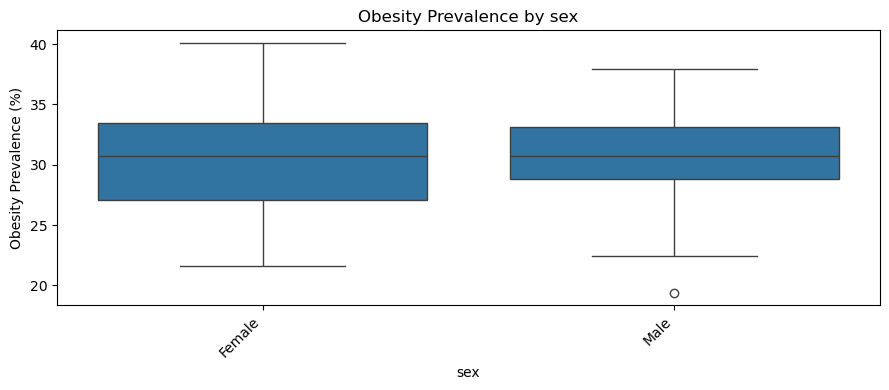

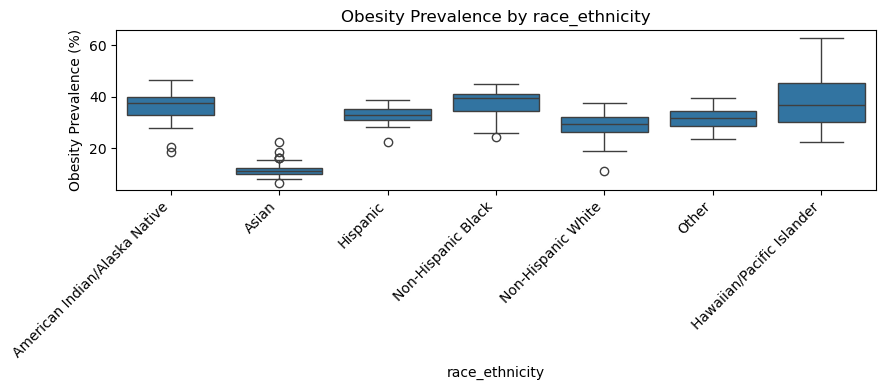


mean obesity by income:
income
Less than 15000     35.09
15000 - 24999       33.72
25000 - 34999       32.72
35000 - 49999       32.44
50000 - 74999       31.94
NaN                 30.58
75000 or greater    27.90
Name: obesity_pct, dtype: float64

mean obesity by sex:
sex
NaN       31.03
Female    30.70
Male      30.56
Name: obesity_pct, dtype: float64

mean obesity by race_ethnicity:
race_ethnicity
Hawaiian/Pacific Islander        38.80
Non-Hispanic Black               37.58
American Indian/Alaska Native    36.39
Hispanic                         32.92
Other                            31.87
NaN                              31.13
Non-Hispanic White               28.79
Asian                            11.81
Name: obesity_pct, dtype: float64

mean obesity by education:
education
<High school         34.06
High school          32.75
Some college/tech    32.36
NaN                  30.98
College              25.23
Name: obesity_pct, dtype: float64

mean obesity by ageyears:
ageyears
45-54  

In [ ]:
#bivariate eda

short_labels = {
    "Q018": "Low Veg Intake",
    "Q019": "Low Fruit Intake",
    "Q036": "Adults w/ Obesity",
    "Q037": "Adults Overweight",
    "Q043": "≥150min Aerobic Activity",
    "Q044": "≥150min Aerobic + Strength 2d",
    "Q045": "≥300min Aerobic Activity",
    "Q046": "Strength Train ≥2d",
    "Q047": "No Leisure Activity",
}

#choose behavior columns (q_*) with most data and some variability
beh_cols_all = [c for c in obesity_behavior.columns if c.startswith("Q")]
beh_nonnull = [(c, obesity_behavior[c].notna().sum(), obesity_behavior[c].nunique(dropna=True)) for c in beh_cols_all]
beh_ranked = [c for c,nn,uq in sorted(beh_nonnull, key=lambda x:(-x[1], -x[2]))]
beh_top = beh_ranked[:9] if len(beh_ranked)>=6 else beh_ranked

#scatterplots obesity vs selected behaviors
for c in beh_top:


    plt.figure(figsize=(6,4))
    sns.scatterplot(data=obesity_behavior, x=c, y="obesity_pct", alpha=0.4)
    sns.regplot(data=obesity_behavior, x=c, y="obesity_pct", scatter=False, color="red")
    label = c

     #short label mapping
    try:
        label = short_labels.get(c, c)
    except:
        pass

    plt.title(f"Obesity vs {label}")
    plt.xlabel(label)
    plt.ylabel("Obesity Prevalence (%)")
    plt.tight_layout(); plt.show()

#boxplots obesity vs categorical predictors
cat_preds = ["sex","race_ethnicity"]
for c in cat_preds:
    if c in obesity_behavior.columns:
        plt.figure(figsize=(9,4))
        sns.boxplot(data=obesity_behavior, x=c, y="obesity_pct")
        plt.title(f"Obesity Prevalence by {c}")
        plt.ylabel("Obesity Prevalence (%)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout(); plt.show()

#grouped summaries (means)
for c in ["income","sex","race_ethnicity","education","ageyears"]:
    if c in obesity_behavior.columns:
        grp = obesity_behavior.groupby(c, dropna=False)["obesity_pct"].mean().sort_values(ascending=False)
        print(f"\nmean obesity by {c}:\n{grp.round(2)}")


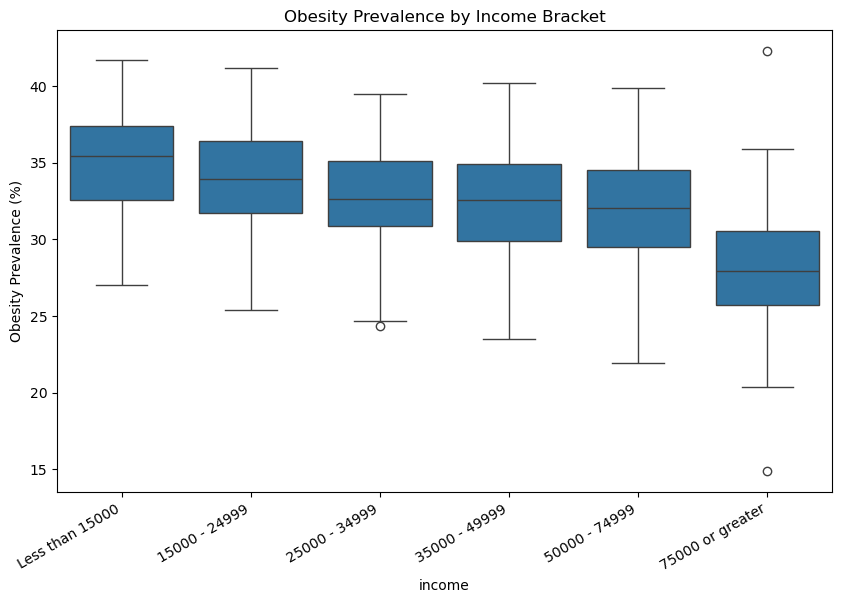

In [ ]:
# --- Define manual income order ---
income_order = [
    "Less than 15000",
    "15000 - 24999",
    "25000 - 34999",
    "35000 - 49999",
    "50000 - 74999",
    "75000 or greater"
]

# --- Boxplot with manual ordering ---
plt.figure(figsize=(10,6))
sns.boxplot(
    data=obesity_behavior,  # or your relevant dataframe
    x="income",
    y="obesity_pct",
    order=income_order
)
plt.title("Obesity Prevalence by Income Bracket")
plt.ylabel("Obesity Prevalence (%)")
plt.xticks(rotation=30, ha="right")
plt.show()

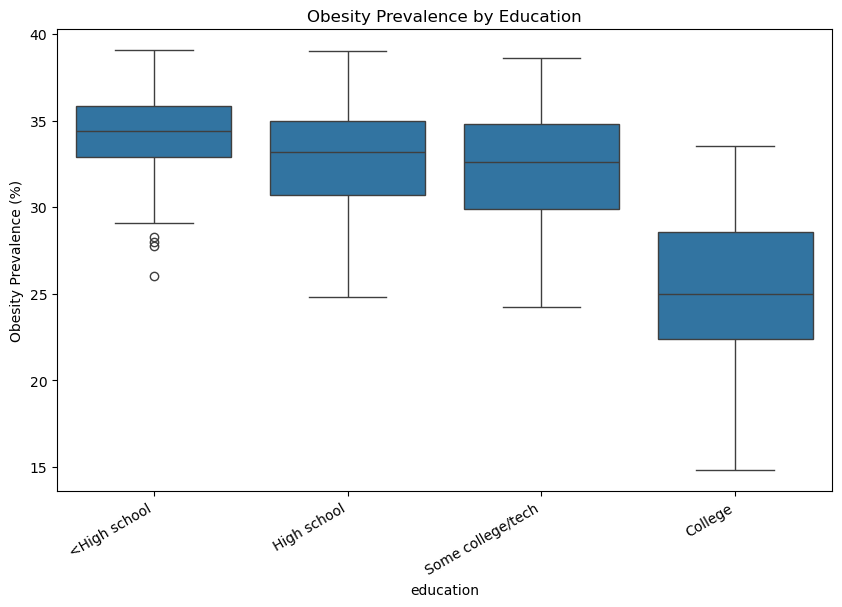

In [ ]:
# --- Define manual education order ---
edu_order = [
    "<High school",
    "High school",
    "Some college/tech",
    "College"
]

# --- Boxplot with manual ordering ---
plt.figure(figsize=(10,6))
sns.boxplot(
    data=obesity_behavior,  # or your relevant dataframe
    x="education",
    y="obesity_pct",
    order=edu_order
)
plt.title("Obesity Prevalence by Education")
plt.ylabel("Obesity Prevalence (%)")
plt.xticks(rotation=30, ha="right")
plt.show()

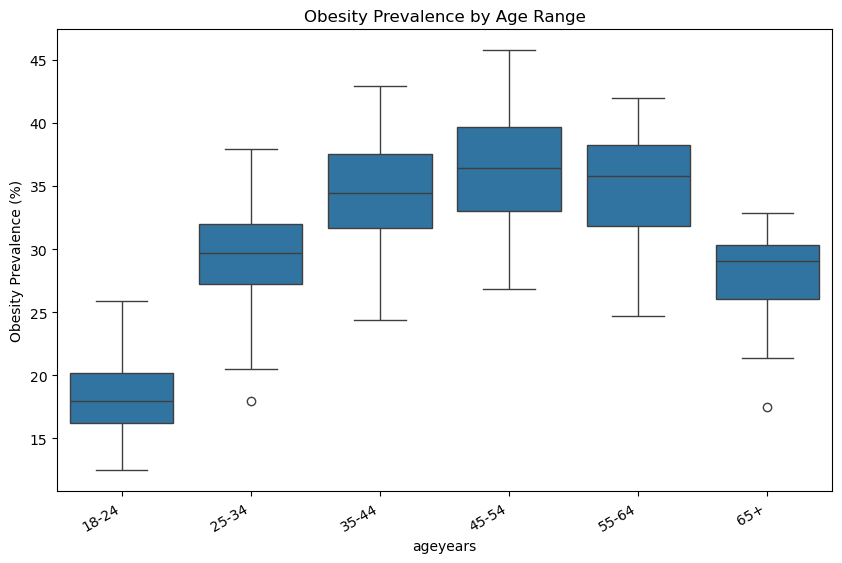

In [ ]:
# --- Define manual education order ---
age_order = [
    "18-24",
    "25-34",
    "35-44",
    "45-54",
    "55-64",
    "65+"
]

# --- Boxplot with manual ordering ---
plt.figure(figsize=(10,6))
sns.boxplot(
    data=obesity_behavior,  # or your relevant dataframe
    x="ageyears",
    y="obesity_pct",
    order=age_order
)
plt.title("Obesity Prevalence by Age Range")
plt.ylabel("Obesity Prevalence (%)")
plt.xticks(rotation=30, ha="right")
plt.show()

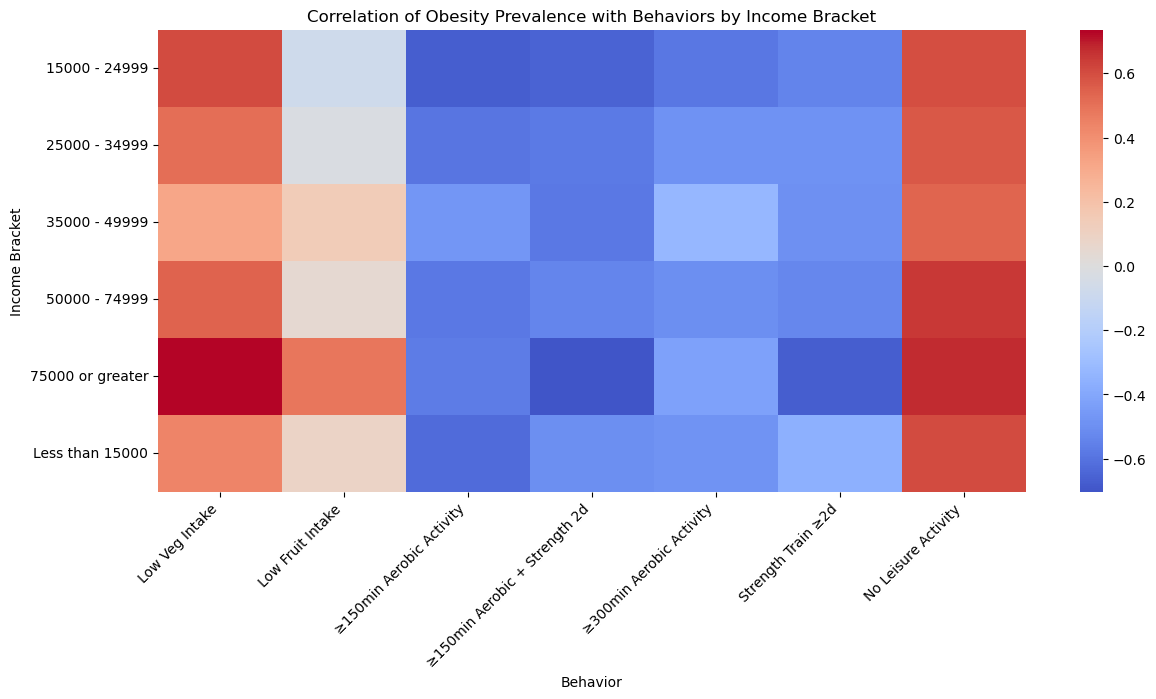

In [ ]:
#qID to message map, updated to match ajaya

short_labels = {
    "Q018": "Low Veg Intake",
    "Q019": "Low Fruit Intake",
    "Q036": "Adults w/ Obesity",
    "Q037": "Adults Overweight",
    "Q043": "≥150min Aerobic Activity",
    "Q044": "≥150min Aerobic + Strength 2d",
    "Q045": "≥300min Aerobic Activity",
    "Q046": "Strength Train ≥2d",
    "Q047": "No Leisure Activity",
}

# fallback just use the questionid
qid_map_short = {
    qid: short_labels.get(qid, qid)
    for qid in df["questionid"].unique()
}

#corr matrix income x behaviors
def build_income_behavior_corr(df):
    behaviors = [c for c in df.columns if c.startswith("Q")]
    behaviors_qid = [b.replace("Q","") for b in behaviors]
    income_groups = df["income"].dropna().unique()

    corr_matrix = pd.DataFrame(index=income_groups, columns=behaviors, dtype=float)

    for inc in income_groups:
        df_inc = df[df["income"] == inc]
        data = df_inc[["obesity_pct"] + behaviors].dropna()
        if data.shape[0] >= 5:
            corrs = data.corr()["obesity_pct"].drop("obesity_pct")
            corr_matrix.loc[inc, corrs.index] = corrs.values

    #rename cols
    rename_map = {f"Q{qid}": qid_map_short.get(qid, f"Q{qid}") for qid in behaviors_qid}
    corr_matrix = corr_matrix.rename(columns=rename_map)

    return corr_matrix

#build matrix
income_behavior_corr = build_income_behavior_corr(obesity_behavior)

#conv to short labels
rename_map = {qid: short_labels.get(qid, qid) for qid in income_behavior_corr.columns}

#rename columns
income_behavior_corr = income_behavior_corr.rename(columns=rename_map)

#plot summary heatmap
plt.figure(figsize=(14,6))
sns.heatmap(income_behavior_corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation of Obesity Prevalence with Behaviors by Income Bracket")
plt.ylabel("Income Bracket")
plt.xlabel("Behavior")
plt.xticks(rotation=45, ha="right")
plt.show()


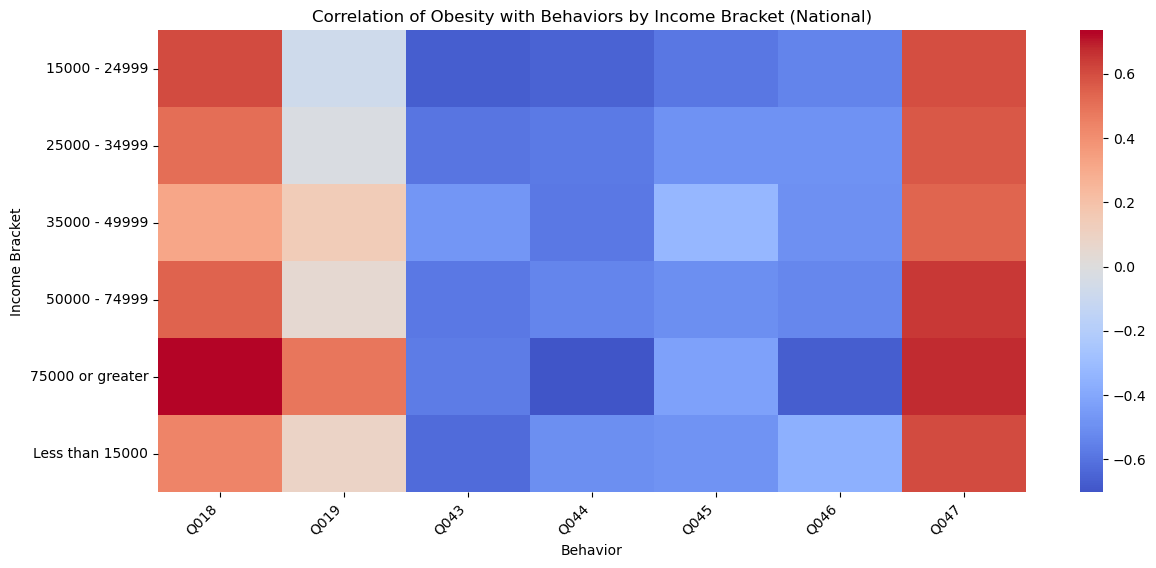

In [ ]:
# --- function for income vs behaviors correlation ---

def income_behavior_corr_heatmap(df, title="US Overall"):
    corr = build_income_behavior_corr(df)
    plt.figure(figsize=(14,6))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(f"Correlation of Obesity with Behaviors by Income Bracket ({title})")
    plt.ylabel("Income Bracket")
    plt.xlabel("Behavior")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    return corr

# --- run for national (all states) ---
corr_us = income_behavior_corr_heatmap(obesity_behavior, title="National")



In [ ]:

#output folder
os.makedirs("results", exist_ok=True)

#single func for all groups corrs
def build_group_behavior_corr(df, group_col):
    behaviors = [c for c in df.columns if c.startswith("Q")]
    behaviors_qid = [b.replace("Q","") for b in behaviors]
    groups = df[group_col].dropna().unique()

    corr_matrix = pd.DataFrame(index=groups, columns=behaviors, dtype=float)

    for g in groups:
        df_g = df[df[group_col] == g]
        data = df_g[["obesity_pct"] + behaviors].dropna()
        if data.shape[0] >= 5:
            corrs = data.corr()["obesity_pct"].drop("obesity_pct")
            corr_matrix.loc[g, corrs.index] = corrs.values

    # rename columns to short labels
    rename_map = {f"{qid}": qid_map_short.get(qid, f"{qid}") for qid in behaviors_qid}
    corr_matrix = corr_matrix.rename(columns=rename_map)
    return corr_matrix

#build corr tables
corr_income = build_group_behavior_corr(obesity_behavior, "income")
corr_race   = build_group_behavior_corr(obesity_behavior, "race_ethnicity")
corr_sex    = build_group_behavior_corr(obesity_behavior, "sex")
corr_edu    = build_group_behavior_corr(obesity_behavior, "education")

#colorscale
vmin = min(c.min().min() for c in [corr_income, corr_race, corr_sex, corr_edu])
vmax = max(c.max().max() for c in [corr_income, corr_race, corr_sex, corr_edu])

#plot helper
def plot_and_export(corr, title, fname):

    #shortlabel
    rename_map = {qid: short_labels.get(qid, qid) for qid in corr.columns}

    # rename columns
    corr = corr.rename(columns=rename_map)


    plt.figure(figsize=(14,6))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel(corr.index.name if corr.index.name else "")
    plt.xlabel("Behavior")
    plt.xticks(rotation=45, ha="right")
    outpath = f"results/{fname}.png"
    plt.savefig(outpath, bbox_inches="tight", dpi=300)
    plt.close()
    print("saved fig:", outpath)

    #export table
    csvpath = f"results/{fname}.csv"
    corr.to_csv(csvpath)
    print("saved table:", csvpath)

#execute
plot_and_export(corr_income, "Obesity vs Behaviors by Income Bracket", "corr_income")
plot_and_export(corr_race,   "Obesity vs Behaviors by Race/Ethnicity", "corr_race")
plot_and_export(corr_sex,    "Obesity vs Behaviors by Sex",            "corr_sex")
plot_and_export(corr_edu,    "Obesity vs Behaviors by Education",      "corr_education")


saved fig: results/corr_income.png
saved table: results/corr_income.csv
saved fig: results/corr_race.png
saved table: results/corr_race.csv
saved fig: results/corr_sex.png
saved table: results/corr_sex.csv
saved fig: results/corr_education.png
saved table: results/corr_education.csv


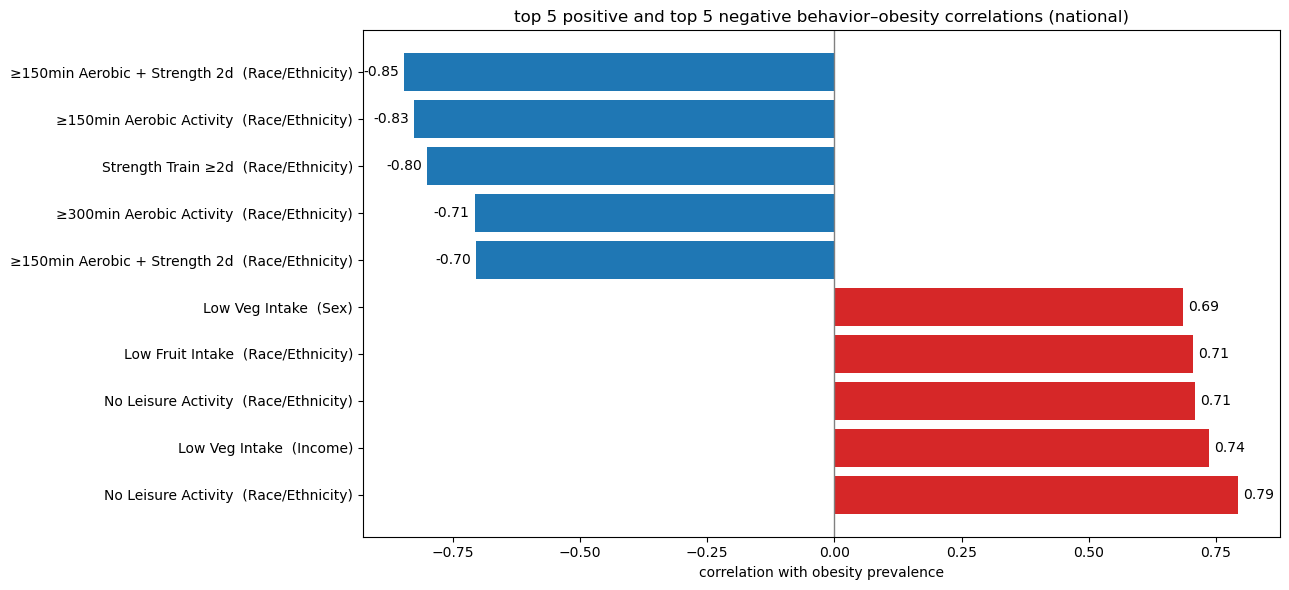

saved figure: results/top_correlates_bar.png


In [ ]:
#test no color
#ensure results folder
os.makedirs("results", exist_ok=True)

#melt helper
def melt_corr(df, group_name):
    idcol = df.index.name if df.index.name is not None else "group_value"
    tmp = df.copy()
    tmp.index.name = idcol
    return tmp.reset_index().melt(id_vars=idcol, var_name="behavior", value_name="corr").assign(group=group_name)

#combine all correlation tables
all_corrs = pd.concat([
    melt_corr(corr_income, "Income"),
    melt_corr(corr_race, "Race/Ethnicity"),
    melt_corr(corr_sex, "Sex"),
    melt_corr(corr_edu, "Education")
], ignore_index=True)

#clean
all_corrs["corr"] = pd.to_numeric(all_corrs["corr"], errors="coerce")
all_corrs = all_corrs.dropna(subset=["corr"])

#select top 5 positive and top 5 negative
top_pos = all_corrs.sort_values("corr", ascending=False).head(5).copy()
top_neg = all_corrs.sort_values("corr", ascending=True).head(5).copy()
top_neg = top_neg.iloc[::-1].copy()  #so most negative at bottom visually

#combine for plotting
top_pos["direction"] = "Positive"
top_neg["direction"] = "Negative"
top = pd.concat([top_pos, top_neg], ignore_index=True)

top["behavior_label"] = top["behavior"].map(short_labels).fillna(top["behavior"])

#format labels
top["label"] = top["behavior_label"] + "  (" + top["group"] + ")"



#plot horizontal bar chart with matplotlib (no seaborn)
plt.figure(figsize=(13,6))
ypos = range(len(top))
colors = ["#d62728" if d=="Positive" else "#1f77b4" for d in top["direction"]]
plt.barh(list(ypos), top["corr"].values, color=colors)
plt.yticks(list(ypos), top["label"])
plt.axvline(0, color="gray", linewidth=1)
plt.xlabel("correlation with obesity prevalence")
plt.title("top 5 positive and top 5 negative behavior–obesity correlations (national)")

#annotate bars with values
for i, v in enumerate(top["corr"].values):
    plt.text(v + (0.01 if v>=0 else -0.01), i, f"{v:.2f}", va="center",
             ha="left" if v>=0 else "right")

plt.tight_layout()
outpath = "results/top_correlates_bar.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()
print("saved figure:", outpath)

In [ ]:
#build stratum-level behavior correlations and exports (national)

#ensure outputs
os.makedirs("results/stratum_corr", exist_ok=True)

#detect behavior columns and short labels
beh_cols = [c for c in obesity_behavior.columns if c.startswith("Q")]
def label_map(cols):
    #use short_labels if present, else fall back to ids
    if "short_labels" in globals():
        return {c: short_labels.get(c[2:], c) for c in cols}
    return {c: c}
beh_rename = label_map(beh_cols)

#core function: stratum x behavior correlations within a stratification category
def build_stratum_behavior_corr(df, strat_col, min_n=5, method="pearson"):
    strata = df[strat_col].dropna().unique()
    mat = pd.DataFrame(index=strata, columns=beh_cols, dtype=float)
    for s in strata:
        sub = df[df[strat_col]==s][["obesity_pct"]+beh_cols].copy()
        sub = sub.dropna(subset=["obesity_pct"])
        #drop all-na or constant predictors within stratum
        keep = ["obesity_pct"] + [c for c in beh_cols if sub[c].notna().any() and sub[c].nunique(dropna=True)>1]
        sub = sub[keep]
        if sub.shape[0] >= min_n and sub.shape[1] >= 2:
            cor = sub.corr(numeric_only=True, method=method)["obesity_pct"].drop("obesity_pct")
            mat.loc[s, cor.index] = cor.values
    #rename behavior columns for readability
    return mat.rename(columns=beh_rename).sort_index()

#plot helper with export
def plot_corr_heatmap(mat, title, fname, vmin=None, vmax=None):
    rename_map = {qid: short_labels.get(qid, qid) for qid in mat.columns}

    # rename columns
    mat = mat.rename(columns=rename_map)

    plt.figure(figsize=(16, max(4, 0.5*len(mat.index))))
    sns.heatmap(mat, annot=False, cmap="viridis", center=0, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel("stratum")
    plt.xlabel("behavior")
    plt.xticks(rotation=45, ha="right")
    out_png = f"results/stratum_corr/{fname}.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close()
    mat.to_csv(f"results/stratum_corr/{fname}.csv")
    print("saved:", out_png)

#build all four stratification views
corr_by_race = build_stratum_behavior_corr(obesity_behavior, "race_ethnicity", min_n=5, method="pearson")
corr_by_sex  = build_stratum_behavior_corr(obesity_behavior, "sex",            min_n=5, method="pearson")
corr_by_inc  = build_stratum_behavior_corr(obesity_behavior, "income",         min_n=5, method="pearson")
corr_by_edu  = build_stratum_behavior_corr(obesity_behavior, "education",      min_n=5, method="pearson")

#shared color scale per-figure set
all_mats = [corr_by_race, corr_by_sex, corr_by_inc, corr_by_edu]
vals = np.concatenate([m.values.flatten() for m in all_mats if m.size>0])
vals = vals[~np.isnan(vals)]
vmin = float(vals.min()) if vals.size else -1.0
vmax = float(vals.max()) if vals.size else 1.0

#export heatmaps and tables
plot_corr_heatmap(corr_by_race, "obesity vs behaviors by race/ethnicity (national, stratum-level)", "corr_stratum_race", vmin, vmax)
plot_corr_heatmap(corr_by_sex,  "obesity vs behaviors by sex (national, stratum-level)",            "corr_stratum_sex",  vmin, vmax)
plot_corr_heatmap(corr_by_inc,  "obesity vs behaviors by income (national, stratum-level)",         "corr_stratum_income", vmin, vmax)
plot_corr_heatmap(corr_by_edu,  "obesity vs behaviors by education (national, stratum-level)",      "corr_stratum_education", vmin, vmax)

#top +/- 3 for each group for interpretation review
def top_k(mat, k=5):
    for s in mat.index:
        row = mat.loc[s].dropna()
        if row.empty:
            continue
        pos = row.sort_values(ascending=False).head(k)
        neg = row.sort_values(ascending=True).head(k)

        #map QID to short label
        pos_labels = [f"{short_labels.get(a, a)}={b:.2f}" for a, b in pos.items()]
        neg_labels = [f"{short_labels.get(a, a)}={b:.2f}" for a, b in neg.items()]

        print(f"\n{s} | top+: " + ", ".join(pos_labels))
        print(f"{s} | top-: " + ", ".join(neg_labels))

print("\n--- review: race/ethnicity ---"); top_k(corr_by_race)
print("\n--- review: sex ---");            top_k(corr_by_sex)
print("\n--- review: income ---");         top_k(corr_by_inc)
print("\n--- review: education ---");      top_k(corr_by_edu)


saved: results/stratum_corr/corr_stratum_race.png
saved: results/stratum_corr/corr_stratum_sex.png
saved: results/stratum_corr/corr_stratum_income.png
saved: results/stratum_corr/corr_stratum_education.png

--- review: race/ethnicity ---

American Indian/Alaska Native | top+: Low Veg Intake=0.48, Low Fruit Intake=0.41, ≥150min Aerobic + Strength 2d=0.19, ≥150min Aerobic Activity=-0.01, Strength Train ≥2d=-0.01
American Indian/Alaska Native | top-: No Leisure Activity=-0.26, ≥300min Aerobic Activity=-0.25, Strength Train ≥2d=-0.01, ≥150min Aerobic Activity=-0.01, ≥150min Aerobic + Strength 2d=0.19

Asian | top+: Low Fruit Intake=0.65, No Leisure Activity=0.62, Low Veg Intake=0.46, ≥300min Aerobic Activity=0.41, ≥150min Aerobic + Strength 2d=-0.02
Asian | top-: ≥150min Aerobic Activity=-0.13, Strength Train ≥2d=-0.05, ≥150min Aerobic + Strength 2d=-0.02, ≥300min Aerobic Activity=0.41, Low Veg Intake=0.46

Hawaiian/Pacific Islander | top+: No Leisure Activity=0.69, Low Veg Intake=0.30, Lo

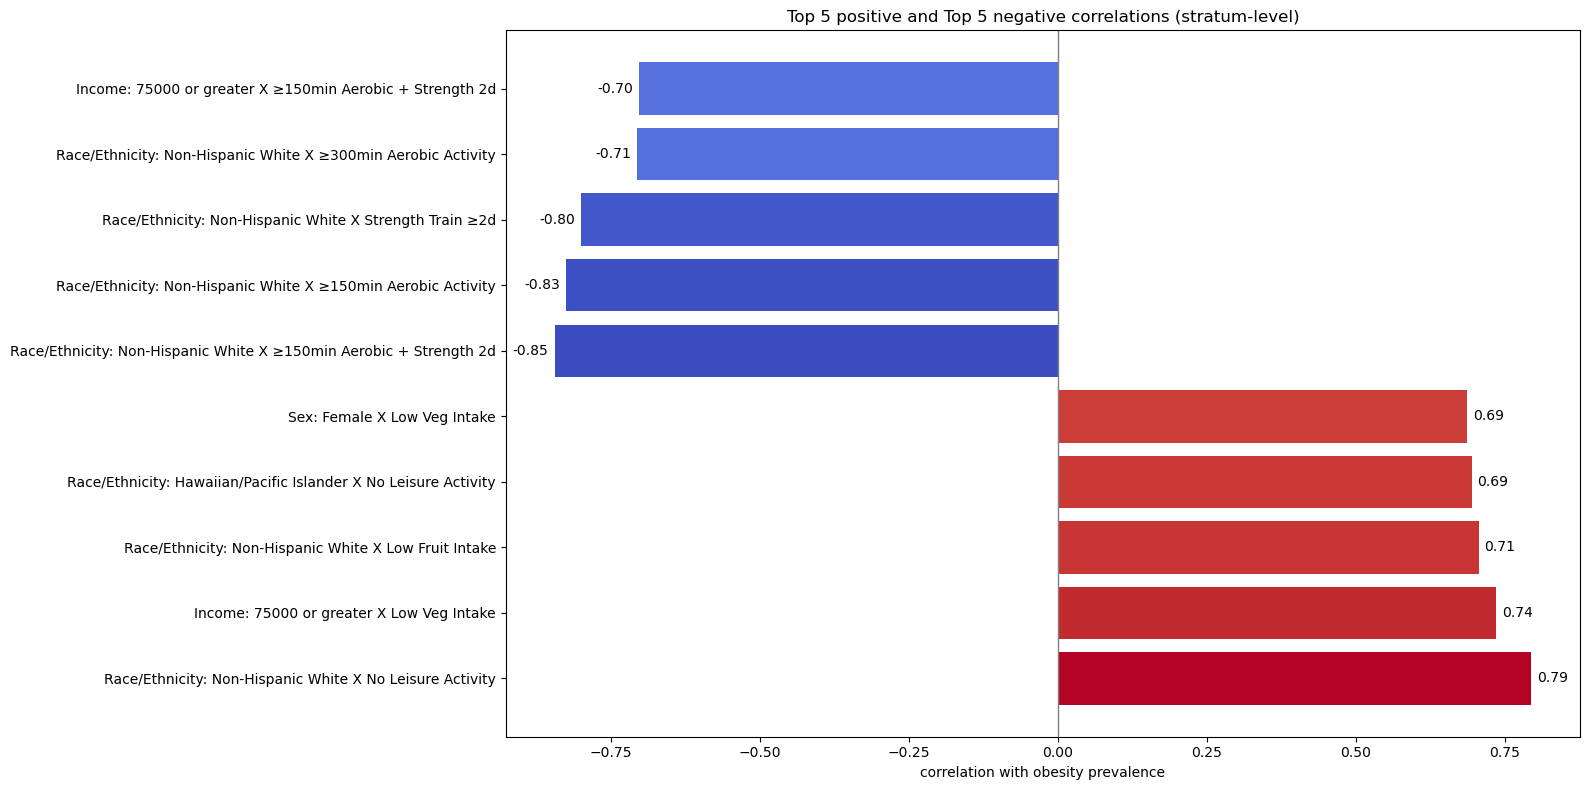

saved figure: results/top10_stratum_correlations.png
saved table: results/top10_stratum_correlations.csv


In [ ]:
#top 10 pos/neg stratum-level correlations with viridis + robust loading and export



#robust-load helper
def load_stratum_df(var_name, local_path, fallback_path):
    if var_name in globals() and isinstance(globals()[var_name], pd.DataFrame):
        return globals()[var_name]
    p = local_path if os.path.exists(local_path) else fallback_path
    return pd.read_csv(p, index_col=0)

#load stratum-level tables (try project paths, fallback to /mnt/data)
stratum_income = load_stratum_df(
    "stratum_income",
    "results/stratum_corr/corr_stratum_income.csv",
    "/mnt/data/corr_stratum_income.csv"
)
stratum_race = load_stratum_df(
    "stratum_race",
    "results/stratum_corr/corr_stratum_race.csv",
    "/mnt/data/corr_stratum_race.csv"
)
stratum_sex = load_stratum_df(
    "stratum_sex",
    "results/stratum_corr/corr_stratum_sex.csv",
    "/mnt/data/corr_stratum_sex.csv"
)
stratum_edu = load_stratum_df(
    "stratum_edu",
    "results/stratum_corr/corr_stratum_education.csv",
    "/mnt/data/corr_stratum_education.csv"
)

#reshape helper
def melt_stratum(df, group_label, id_name="stratum"):
    tmp = df.copy()
    tmp.index.name = id_name
    long = tmp.reset_index().melt(id_vars=id_name, var_name="behavior", value_name="corr")
    long["group"] = group_label
    long["stratum"] = long[id_name].astype(str)
    return long[["group","stratum","behavior","corr"]]

#combine all strata
long_income = melt_stratum(stratum_income, "Income", "income")
long_race   = melt_stratum(stratum_race, "Race/Ethnicity", "race")
long_sex    = melt_stratum(stratum_sex, "Sex", "sex")
long_edu    = melt_stratum(stratum_edu, "Education", "education")

all_stratum_corrs = pd.concat([long_income, long_race, long_sex, long_edu], ignore_index=True)
all_stratum_corrs["corr"] = pd.to_numeric(all_stratum_corrs["corr"], errors="coerce")
all_stratum_corrs = all_stratum_corrs.dropna(subset=["corr"])

#rank top 10 positive and top 10 negative
top5_pos = all_stratum_corrs.sort_values("corr", ascending=False).head(5).copy()
top5_neg = all_stratum_corrs.sort_values("corr", ascending=True).head(5).copy()

#prepare plot table
top10 = pd.concat([top5_pos, top5_neg], ignore_index=True)



#format labels map to short label from q###
top10["behavior_label"] = top10["behavior"].map(short_labels).fillna(top10["behavior"])
top10["label"] = top10["group"] + ": " + top10["stratum"] + " X " + top10["behavior_label"]

#plot with matplotlib + viridis
plt.figure(figsize=(16,8))
y = np.arange(len(top10))
#normalize correlations to [0,1] for colormap
cmap = plt.cm.get_cmap("coolwarm")
cmin, cmax = all_stratum_corrs["corr"].min(), all_stratum_corrs["corr"].max()
norm = (top10["corr"] - cmin) / (cmax - cmin + 1e-12)
colors = cmap(norm.values)
plt.barh(y, top10["corr"].values, color=colors)
plt.yticks(y, top10["label"])
plt.axvline(0, color="gray", linewidth=1)
plt.xlabel("correlation with obesity prevalence")
plt.title("Top 5 positive and Top 5 negative correlations (stratum-level)")
#annotate values
for i, v in enumerate(top10["corr"].values):
    plt.text(v + (0.01 if v>=0 else -0.01), i, f"{v:.2f}", va="center",
             ha="left" if v>=0 else "right")
plt.tight_layout()

#export fig and csv
os.makedirs("results", exist_ok=True)
fig_path = "results/top10_stratum_correlations.png"
csv_path = "results/top10_stratum_correlations.csv"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
top10_out = top10[["group","stratum","behavior","corr"]].copy()
top10_out.to_csv(csv_path, index=False)
print("saved figure:", fig_path)
print("saved table:", csv_path)
